In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error

In [2]:
# Variabili globali

path = 'pala_ok/acquisizione 22-05-2023/'

In [3]:
allacqui_temp = []

allacqui_input = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


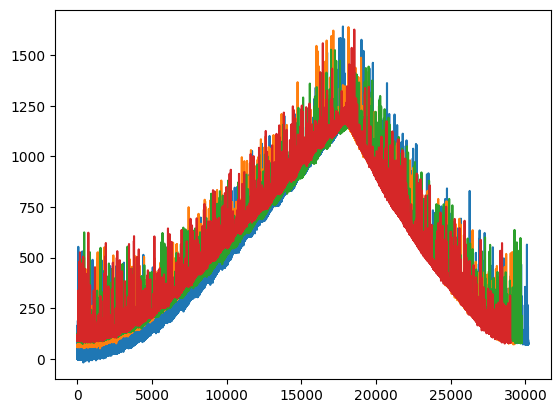

In [4]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,len(path_acquisizioni))):
    if("input" in a):
        allacqui_input.append(pd.read_csv(path+a,sep='\t'))
    else:
        allacqui_temp.append(pd.read_csv(path+a,sep='\t'))

allacqui = []
for a,b in zip(allacqui_temp,range(len(allacqui_temp))):
    if(b % 3 ==0):
        allacqui.append([])
        a['Voltage'] = (10 - a['Voltage'])*500
        plt.plot(a['Voltage'])
    allacqui[-1].append(a)




In [5]:
print(len(allacqui_input))
print(len(allacqui))
print(len(allacqui[0]))
#print(allacqui)

4
4
3


In [6]:
# Check delle dimensioni

print(type(allacqui[0][0][:10].mean()))

for a in range(len(allacqui[0])):
    print(allacqui[0][a].shape)

<class 'pandas.core.series.Series'>
(30192, 2)
(29638, 2)
(29639, 2)


In [7]:
media_mobile_ni = pd.DataFrame(columns=[])

for b in range(0,allacqui[0][0].shape[0],1):
    media_mobile_ni = pd.concat([media_mobile_ni,pd.DataFrame(allacqui[0][0][b:10+b].mean()).transpose()],ignore_index=True)

allacqui[0][0] = media_mobile_ni

In [8]:
print(type(allacqui[0][0]))
print(allacqui[0][0].head(10))

<class 'pandas.core.frame.DataFrame'>
           time    Voltage
0  1.684771e+15   0.814865
1  1.684771e+15   0.524087
2  1.684771e+15  16.920726
3  1.684771e+15  17.017652
4  1.684771e+15  16.662257
5  1.684771e+15  16.355325
6  1.684771e+15  16.533023
7  1.684771e+15  16.823800
8  1.684771e+15  16.904572
9  1.684771e+15  16.549177


In [10]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = allacqui[0][2]['volts']
grid_points = allacqui[0][2]['time']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=3)
)

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


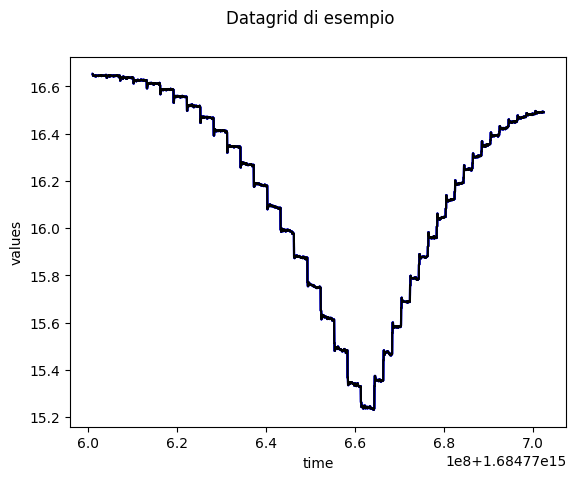

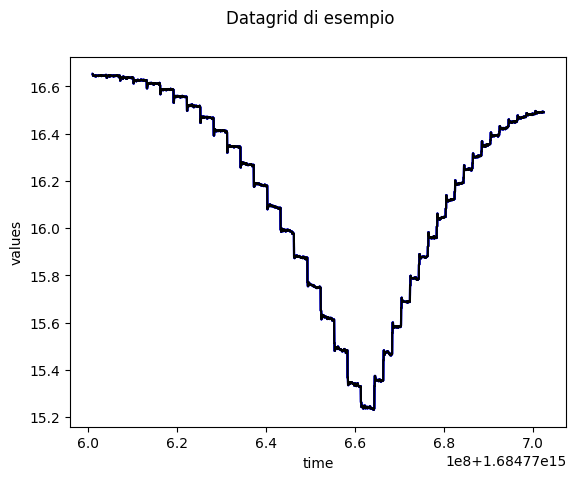

In [11]:
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [12]:
import numpy as np
def makepwm(d):
    off_setList = len([d-x for x in b['time'] if (d - x > 0)])
    if(off_setList == 0):
       return 0
    else:
      return b['pwm_percent'][off_setList-1]
makepwmElem = np.vectorize(makepwm)

In [13]:
all_PWMoutput = []

for acquisizione,b in zip(allacqui,allacqui_input): 
    
    all_PWMoutput.append([])
    for timestamp in acquisizione:
        all_PWMoutput[-1].append([])
        all_PWMoutput[-1][-1] = makepwmElem(timestamp['time'])
        


In [15]:
print(len(all_PWMoutput))

print(all_PWMoutput[0][0][0])

4
2


In [17]:
print(all_PWMoutput)
print(len(all_PWMoutput))
print(len(all_PWMoutput[0]))

for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    for a,b in zip(pwmoutput,acqui):

        print(len(a))
        print(type(a))
        print(len(b))
        print(type(b))
        print(' Questi sono i valori di a e b')

    

[[array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)], [array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)], [array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)], [array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)]]
4
3
30192
<class 'numpy.ndarray'>
30192
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29638
<class 'numpy.ndarray'>
29638
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29639
<class 'numpy.ndarray'>
29639
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29272
<class 'numpy.ndarray'>
29272
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29295
<class 'numpy.ndarray

In [18]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []

for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    for a,b in zip(acqui,pwmoutput):
    
        data_matrix = np.stack((np.array(a[a.columns.values[1]]), np.array(b)))
        grid_points = a[a.columns.values[0]]

        print(b)

        all_data_grid.append(skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
        dataset_name='pippo',
        argument_names=(a.columns.values[0],),
        coordinate_names=(a.columns.values[1],),
        interpolation=SplineInterpolation(interpolation_order=1)
        ))
    

[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]
[2 2 2 ... 5 5 5]


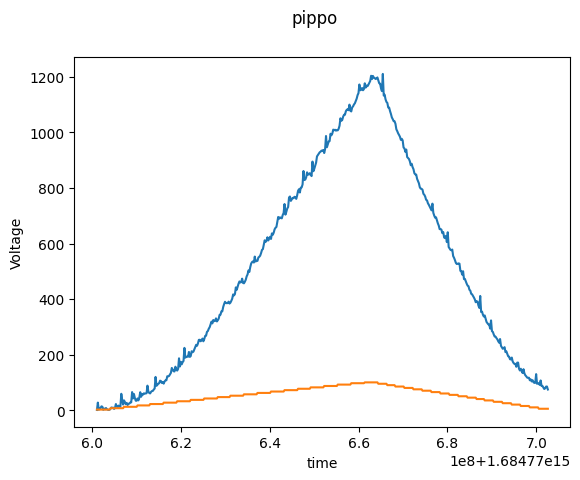

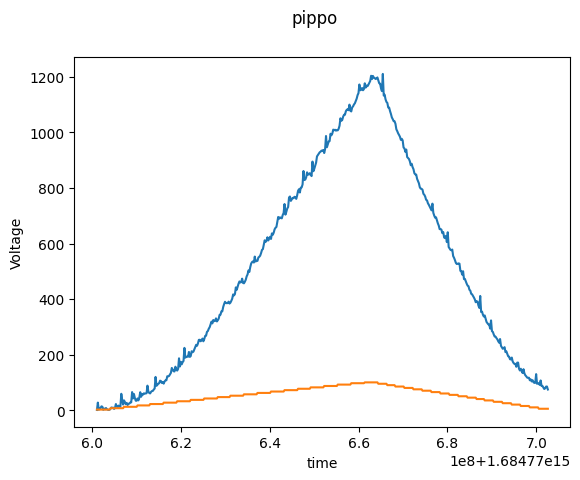

In [19]:
all_data_grid[0].plot()

1222.0979224017356


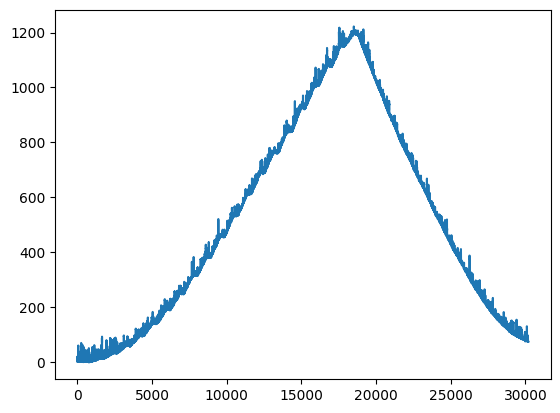

In [20]:
print(all_data_grid[0].data_matrix[0].max())
plt.plot(all_data_grid[0].data_matrix[0])


In [83]:
fit_result_5 = polyfit(all_data_grid[0].data_matrix[1][:,0],all_data_grid[0].data_matrix[0],deg=5)
fit_result_4 = polyfit(all_data_grid[0].data_matrix[1][:,0],all_data_grid[0].data_matrix[0],deg=4)
# per fare test
fit_result_3 = polyfit(all_data_grid[0].data_matrix[1][:,0],all_data_grid[0].data_matrix[0],deg=3)
fit_result_2 = polyfit(all_data_grid[0].data_matrix[1][:,0],all_data_grid[0].data_matrix[0],deg=2)
fit_result_1 = polyfit(all_data_grid[0].data_matrix[1][:,0],all_data_grid[0].data_matrix[0],deg=1)

In [38]:
print(all_data_grid[0].data_matrix[1].shape)

(30192, 1)


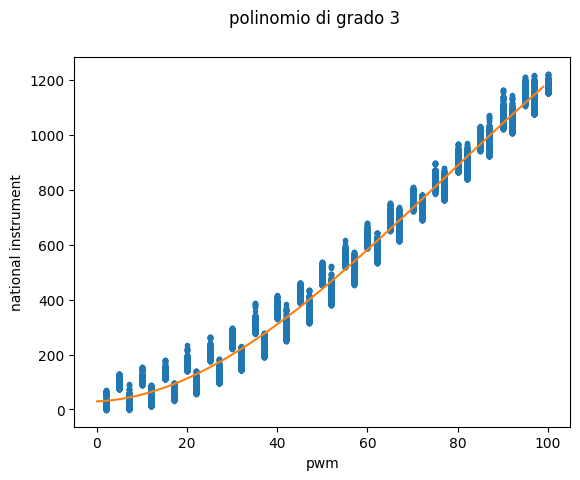

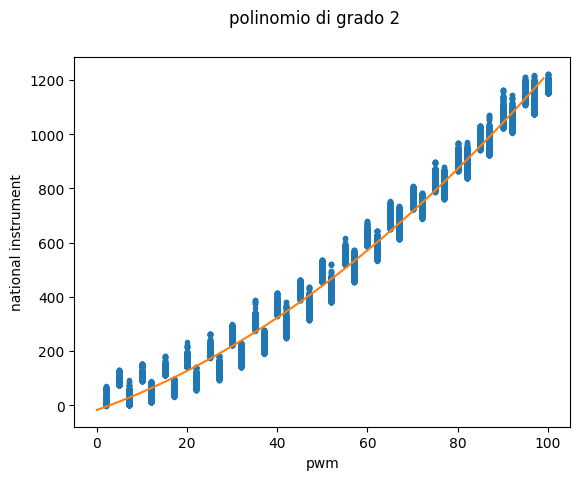

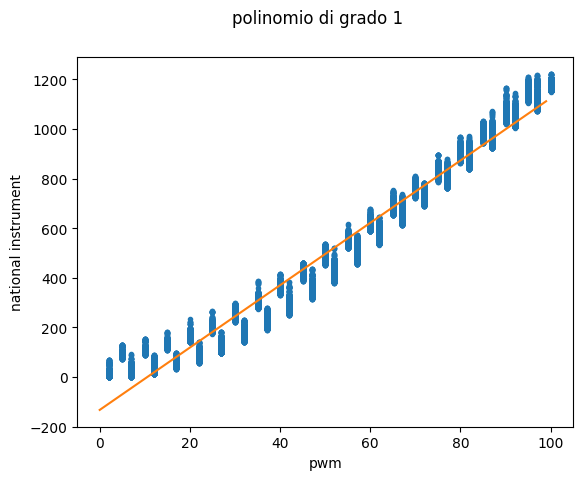

In [89]:
# Sample data

allpoly= [fit_result_3,fit_result_2,fit_result_1]

for a,indice in zip(allpoly,range(3,0,-1)):
    fig, axs = plt.subplots(nrows = 1, ncols = 1)
    linex = np.arange(0,100,1)
    plotRes = 0
    for i in range(len(a)):
        plotRes += a[i]*linex**i

    fig.suptitle('polinomio di grado '+str(indice))
    axs.set_xlabel('pwm')
    axs.set_ylabel('national instrument')
    axs.plot(all_data_grid[0].data_matrix[1][:,0],all_data_grid[0].data_matrix[0],'.')
    axs.plot(linex, plotRes,'-')


#r = np.corrcoef(all_data_grid[0].data_matrix[1][:,0],all_data_grid[0].data_matrix[0])

In [69]:
fit_result_3.shape

(4, 1)

In [70]:
# Andiamo a calcolare il mean squared error

y_pred = all_data_grid[0].data_matrix[0]
y_true = 0

for i in range(len(fit_result_3)):
    y_true += fit_result_3[i]*all_data_grid[0].data_matrix[1][:,0]**i

In [76]:
# Andiamo a calcolare il mean squared error

y_pred_2 = all_data_grid[0].data_matrix[0][:,0]
y_true_2 = 0

for i in range(len(fit_result_2)):
    y_true_2 += fit_result_2[i]*all_data_grid[0].data_matrix[1][:,0]**i

In [79]:
# Andiamo a calcolare il mean squared error

y_pred_1 = all_data_grid[0].data_matrix[0][:,0]
y_true_1 = 0

for i in range(len(fit_result_1)):
    y_true_1 += fit_result_1[i]*all_data_grid[0].data_matrix[1][:,0]**i

In [84]:
# Andiamo a calcolare il mean squared error

y_pred_4 = all_data_grid[0].data_matrix[0][:,0]
y_true_4 = 0

for i in range(len(fit_result_4)):
    y_true_4 += fit_result_4[i]*all_data_grid[0].data_matrix[1][:,0]**i

In [85]:
# Andiamo a calcolare il mean squared error

y_pred_5 = all_data_grid[0].data_matrix[0][:,0]
y_true_5 = 0

for i in range(len(fit_result_5)):
    y_true_5 += fit_result_5[i]*all_data_grid[0].data_matrix[1][:,0]**i

In [86]:
print('grado 3')
print(mean_squared_error(y_true, y_pred[:,0]))
print('grado 2')
print(mean_squared_error(y_true_2, y_pred_2))
print('grado 1')
print(mean_squared_error(y_true_1, y_pred_1))
print('grado 4')
print(mean_squared_error(y_true_4, y_pred_4))
print('grado 5')
print(mean_squared_error(y_true_5, y_pred_5))

grado 3
1751.001597082054
grado 2
2004.2624264195001
grado 1
4422.218527613603
grado 4
1750.9145016853352
grado 5
1750.6180045020296
